In [47]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Import Required Library

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.optim import lr_scheduler

from tqdm import tqdm

import random
import PIL 
from PIL import Image

from torch.autograd import Variable
from collections import OrderedDict
import math
from pathlib import Path
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version {torch.__version__}\nPIL version {PIL.__version__}\nDevice {device}")

torch version 1.6.0
PIL version 7.0.0
Device cuda


## Dataset

In [49]:
dataset = datasets.CIFAR10(train=True,root="data/" , download=False)

In [50]:
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [51]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [52]:
dataset.data.shape

(50000, 32, 32, 3)

#### Mean and Std calculation for Normalization

In [53]:
mean = np.mean(dataset.data ,axis=(0,1,2))
std = np.std(dataset.data ,axis=(0,1,2))
print(f"\nMean is {mean}\nStd dev is  {std}")


Mean is [125.30691805 122.95039414 113.86538318]
Std dev is  [62.99321928 62.08870764 66.70489964]


## Transformation and Dataset Defination

* Random crop
* RandomHorizontalFlip

In [54]:
mean = torch.from_numpy(mean).type(torch.float32)
std = torch.from_numpy(std).type(torch.float32)
mean, std

(tensor([125.3069, 122.9504, 113.8654]), tensor([62.9932, 62.0887, 66.7049]))

In [55]:
train_transforms = transforms.Compose([transforms.RandomCrop(size=32 , padding=4 , padding_mode="symmetric",pad_if_needed=True),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      ])#transforms.Normalize(mean = mean , std=std)])

val_transforms = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize(mean=mean , std=std)])


### Denormalization

In [56]:
def denormalize(image):
    image = image.clone().detach().to("cpu") # take out of computational graph
    image = image.squeeze() 
    image = image.permute(1,2,0) # channel swapping H*W*C
    # image.mul_(std).add_(mean) # denormalize

    return image.numpy()

In [57]:
trainset = datasets.CIFAR10(train=True,root="data/" , download=False,transform=train_transforms)
valset  = datasets.CIFAR10(train=False,root="data/" , download=False,transform=val_transforms)

In [58]:
trainset.data.shape, valset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Augmentation Visualization¶

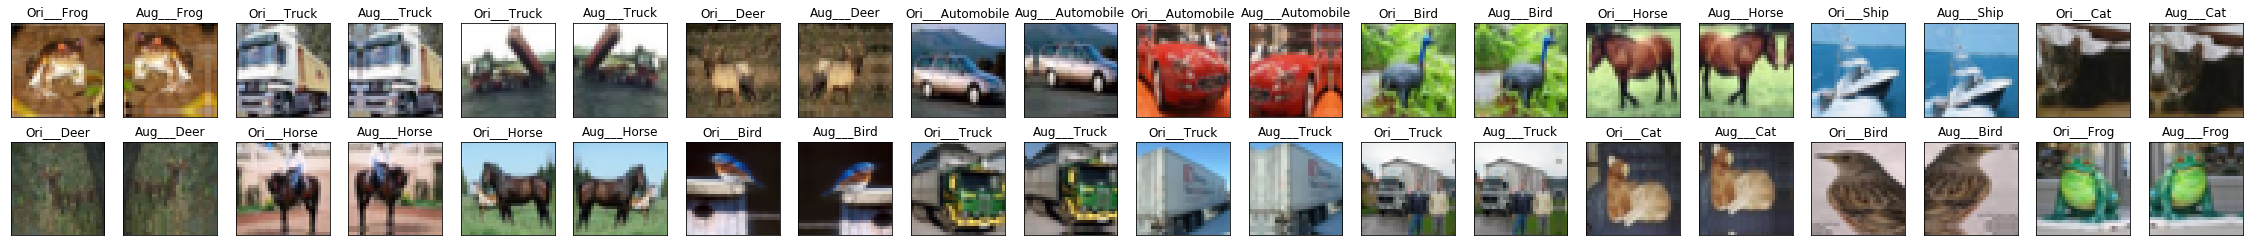

In [59]:
def show_img(ax,img,text):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(img)
    ax.set_title(text.title())

def visualizeAugmentation(augSet , normalset , no_of_images=8):
    """
    Visualizing Augmentation with normal set
    :augset : Augmented dataset
    :normalset :Normal dataset with no Augmentation
    """
    fig = plt.figure(figsize=(no_of_images*2,4))

    l = [x for x in range(1,2*no_of_images+1)] #indexing purpose 

    for i in range(no_of_images):
    
        ax  = fig.add_subplot(2,no_of_images,l[::2][i]) #odd numbers 
        ax2 = fig.add_subplot(2,no_of_images,l[1::2][i]) #even numbers

        show_img(ax , normalset[i][0],f"ori___{normalset.classes[normalset[i][1]]}")
        show_img(ax2 , denormalize(augSet[i][0]), f"aug___{augSet.classes[augSet[i][1]]}")

visualizeAugmentation(trainset, dataset,no_of_images=20)

## Utility Func

In [60]:
from functools import wraps

def no_grad(func):
    @wraps(func)
    def wrapper(*args,**kwargs):
        with torch.no_grad():
            return func(*args,**kwargs)
    return wrapper

## Save Checkpoint

In [61]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer,loss, best_loss, is_best,filepath=None):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path(r"C:\Users\91892\Documents\Python_jupyter\Deep Learning\Assignment\Densenet\BEST_checkpoint2.pt") if filepath is None else filepath
    is_best = is_best if filepath is None else False
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path(r"C:\Users\91892\Documents\Python_jupyter\Deep Learning\Assignment\Densenet\BEST_checkpoint2.pt"))

## Model Definition

### Model Summary

In [62]:
@no_grad
def summary(model, input_size, batch_size=-1, device="cuda"):

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []
    model = model.to(device)
    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size
    
    del model
    
    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    return total_params

### Dense Net

#### Bottle Neck

* BatchNorm(x) -> Relu(x) -> Conv1(x) -> x1
* BatchNorm(x1) -> Relu(x1) -> Conv2(x1) -> x2
* Dropout(x2) -> x2

In [63]:
class BottleNeck(nn.Module):
    def __init__(self,num_channels,growth_rate,bn_size,drop_rate):
        super(BottleNeck ,self).__init__()
        mid_channel = int(bn_size*growth_rate)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels,mid_channel ,kernel_size=1 , bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channel)
        self.conv2 = nn.Conv2d(mid_channel ,growth_rate , kernel_size=3 , bias=False,padding=1)
        self.drop_rate=drop_rate
    
    def forward(self,x):
        new_features = self.conv1(F.leaky_relu(self.bn1(x)))
        new_features = self.conv2(F.leaky_relu(self.bn2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return(torch.cat([x,new_features],1))

In [64]:
# Bottle Neck test
BottleNeck(24,12,4,0.3)

BottleNeck(
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

#### Transition

In [65]:
class Transition(nn.Module):
    def __init__(self, num_channels, num_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels, num_out_channels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.leaky_relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [66]:
(30-3)//3

9

#### Artitechture

In [67]:
class DenseNet(nn.Module):
  
    def __init__(self, growth_rate, depth, reduction , num_classes,bn_size=4,drop_rate=0.15):
        super(DenseNet , self).__init__()

        no_of_dense_blocks = (depth-3)//3 #16
        num_channels = 2*growth_rate #24,

        self.conv1 = nn.Conv2d(3,num_channels , kernel_size=3 ,padding=1,bias=False) #first conv layer

        self.dense_block1 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # first dense block
        num_channels += no_of_dense_blocks * growth_rate
        num_out_channels = int(math.floor(num_channels*reduction))
        self.trans_block1 = Transition(num_channels , num_out_channels) #first transition block

        num_channels = num_out_channels
        self.dense_block2 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # second dense block
        num_channels += no_of_dense_blocks * growth_rate
        num_out_channels = int(math.floor(num_channels*reduction))
        self.trans_block2 = Transition(num_channels , num_out_channels) #first transition block

        num_channels = num_out_channels
        self.dense_block3 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) #third Dense block
        num_channels += no_of_dense_blocks * growth_rate

        self.bn1 = nn.BatchNorm2d(num_channels) # final batch norm
        self.pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)

        ## classifier
        self.classifier = self.create_head(num_channels , num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def _gen_dense_block(self,num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate):
        return nn.Sequential(*[ BottleNeck(int(num_channels+i*growth_rate) , growth_rate,bn_size,drop_rate) for i in range(no_of_dense_blocks)]) 
  
    def create_head(self,num_features , number_classes ,dropout_prob=0.15 ,activation_func =nn.LeakyReLU):
        features_lst = [num_features , num_features//2 , num_features//4]
        layers = []
        for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
            layers.append(nn.Linear(in_f , out_f))
            layers.append(activation_func())
            layers.append(nn.BatchNorm1d(out_f))
            if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(features_lst[-1] , number_classes))
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.trans_block1(self.dense_block1(x))
        x = self.trans_block2(self.dense_block2(x))
        x = self.pool(F.leaky_relu(self.bn1(self.dense_block3(x))))
        x = x.view(x.size(0) , -1)
        x = self.classifier(x)
        return x

In [68]:
totalparams = summary(DenseNet(growth_rate=12, depth=30, reduction=0.6 , num_classes=len(trainset.classes)),(3,32,32));totalparams

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        BottleNeck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       BottleNeck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1, 48,

tensor(368513)

## Parameters

In [69]:
batch_size=32
checkpoint = Path(r"C:\Users\91892\Documents\Python_jupyter\Deep Learning\Assignment\Densenet\BEST_checkpoint.pt")
start_epoch = 0  # start at this epoch
epochs = 5  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 0  # number of workers for loading data in the DataLoader
lr = 0.01  # learning rate
weight_decay = 1e-4  # weight decay
n_classes = len(trainset.classes)

## DataLoader

In [70]:
'''loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                "shuffle":True}'''

trainLoader = DataLoader(trainset,batch_size=batch_size,
                         pin_memory=True, num_workers=workers, shuffle=True)

valLoader = DataLoader(valset,batch_size=batch_size,
                         pin_memory=True, num_workers=workers, shuffle=True)

In [71]:
valLoader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Averge Meter

In [72]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train method

In [73]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    :param optimizer :optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter
    
    # Batches
    #print('here0')
    for images, labels in train_loader:
        #print('here')
        optimizer.zero_grad()
        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images)  
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        
        loss.backward()
        
        
        optimizer.step()

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        
        # Print status
    print(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}")
    return losses.avg

## Validation method

In [74]:
@no_grad
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    """
    model.eval()  # inference mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in val_loader:

        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images) 
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        

        # Print status
    print(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}")
    return losses.avg

## Training

In [75]:
from tqdm import trange
def main(epochs):
    """

    Training and validation.
    """
    global epochs_since_improvement, start_epoch, best_loss, checkpoint
    model = DenseNet(growth_rate=12, depth=30, reduction=0.6 , num_classes=n_classes)
    model = model.to(device)

    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.9,nesterov=True,dampening=0)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=4,min_lr=1e-5,verbose=True)

    # Initialize model or load checkpoint
    if checkpoint.exists():
        checkpoint_dict = torch.load(checkpoint)
        start_epoch = checkpoint_dict['epoch'] + 1
        epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
        best_loss = checkpoint_dict['best_loss']
        print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
        model.load_state_dict(checkpoint_dict['model'])
        optimizer.load_state_dict(checkpoint_dict['optimizer']) 

    # Epochs
    for epoch in trange(start_epoch,start_epoch+epochs):
        print("Current LR is " , optimizer.param_groups[0]['lr'])
        # One epoch's training
        train_loss = train(train_loader=trainLoader,
                         model=model,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epochs)
        #print('here')
        
        # One epoch's validation
        val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)
        scheduler.step(val_loss)
        # Did validation loss improve?
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)
        
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
    return model

In [76]:
model = main(epochs=epochs)


Loaded checkpoint from epoch 25. Best loss so far is 0.299.



RuntimeError: Error(s) in loading state_dict for DenseNet:
	Unexpected key(s) in state_dict: "dense_block1.9.bn1.weight", "dense_block1.9.bn1.bias", "dense_block1.9.bn1.running_mean", "dense_block1.9.bn1.running_var", "dense_block1.9.bn1.num_batches_tracked", "dense_block1.9.conv1.weight", "dense_block1.9.bn2.weight", "dense_block1.9.bn2.bias", "dense_block1.9.bn2.running_mean", "dense_block1.9.bn2.running_var", "dense_block1.9.bn2.num_batches_tracked", "dense_block1.9.conv2.weight", "dense_block1.10.bn1.weight", "dense_block1.10.bn1.bias", "dense_block1.10.bn1.running_mean", "dense_block1.10.bn1.running_var", "dense_block1.10.bn1.num_batches_tracked", "dense_block1.10.conv1.weight", "dense_block1.10.bn2.weight", "dense_block1.10.bn2.bias", "dense_block1.10.bn2.running_mean", "dense_block1.10.bn2.running_var", "dense_block1.10.bn2.num_batches_tracked", "dense_block1.10.conv2.weight", "dense_block1.11.bn1.weight", "dense_block1.11.bn1.bias", "dense_block1.11.bn1.running_mean", "dense_block1.11.bn1.running_var", "dense_block1.11.bn1.num_batches_tracked", "dense_block1.11.conv1.weight", "dense_block1.11.bn2.weight", "dense_block1.11.bn2.bias", "dense_block1.11.bn2.running_mean", "dense_block1.11.bn2.running_var", "dense_block1.11.bn2.num_batches_tracked", "dense_block1.11.conv2.weight", "dense_block1.12.bn1.weight", "dense_block1.12.bn1.bias", "dense_block1.12.bn1.running_mean", "dense_block1.12.bn1.running_var", "dense_block1.12.bn1.num_batches_tracked", "dense_block1.12.conv1.weight", "dense_block1.12.bn2.weight", "dense_block1.12.bn2.bias", "dense_block1.12.bn2.running_mean", "dense_block1.12.bn2.running_var", "dense_block1.12.bn2.num_batches_tracked", "dense_block1.12.conv2.weight", "dense_block1.13.bn1.weight", "dense_block1.13.bn1.bias", "dense_block1.13.bn1.running_mean", "dense_block1.13.bn1.running_var", "dense_block1.13.bn1.num_batches_tracked", "dense_block1.13.conv1.weight", "dense_block1.13.bn2.weight", "dense_block1.13.bn2.bias", "dense_block1.13.bn2.running_mean", "dense_block1.13.bn2.running_var", "dense_block1.13.bn2.num_batches_tracked", "dense_block1.13.conv2.weight", "dense_block1.14.bn1.weight", "dense_block1.14.bn1.bias", "dense_block1.14.bn1.running_mean", "dense_block1.14.bn1.running_var", "dense_block1.14.bn1.num_batches_tracked", "dense_block1.14.conv1.weight", "dense_block1.14.bn2.weight", "dense_block1.14.bn2.bias", "dense_block1.14.bn2.running_mean", "dense_block1.14.bn2.running_var", "dense_block1.14.bn2.num_batches_tracked", "dense_block1.14.conv2.weight", "dense_block1.15.bn1.weight", "dense_block1.15.bn1.bias", "dense_block1.15.bn1.running_mean", "dense_block1.15.bn1.running_var", "dense_block1.15.bn1.num_batches_tracked", "dense_block1.15.conv1.weight", "dense_block1.15.bn2.weight", "dense_block1.15.bn2.bias", "dense_block1.15.bn2.running_mean", "dense_block1.15.bn2.running_var", "dense_block1.15.bn2.num_batches_tracked", "dense_block1.15.conv2.weight", "dense_block2.9.bn1.weight", "dense_block2.9.bn1.bias", "dense_block2.9.bn1.running_mean", "dense_block2.9.bn1.running_var", "dense_block2.9.bn1.num_batches_tracked", "dense_block2.9.conv1.weight", "dense_block2.9.bn2.weight", "dense_block2.9.bn2.bias", "dense_block2.9.bn2.running_mean", "dense_block2.9.bn2.running_var", "dense_block2.9.bn2.num_batches_tracked", "dense_block2.9.conv2.weight", "dense_block2.10.bn1.weight", "dense_block2.10.bn1.bias", "dense_block2.10.bn1.running_mean", "dense_block2.10.bn1.running_var", "dense_block2.10.bn1.num_batches_tracked", "dense_block2.10.conv1.weight", "dense_block2.10.bn2.weight", "dense_block2.10.bn2.bias", "dense_block2.10.bn2.running_mean", "dense_block2.10.bn2.running_var", "dense_block2.10.bn2.num_batches_tracked", "dense_block2.10.conv2.weight", "dense_block2.11.bn1.weight", "dense_block2.11.bn1.bias", "dense_block2.11.bn1.running_mean", "dense_block2.11.bn1.running_var", "dense_block2.11.bn1.num_batches_tracked", "dense_block2.11.conv1.weight", "dense_block2.11.bn2.weight", "dense_block2.11.bn2.bias", "dense_block2.11.bn2.running_mean", "dense_block2.11.bn2.running_var", "dense_block2.11.bn2.num_batches_tracked", "dense_block2.11.conv2.weight", "dense_block2.12.bn1.weight", "dense_block2.12.bn1.bias", "dense_block2.12.bn1.running_mean", "dense_block2.12.bn1.running_var", "dense_block2.12.bn1.num_batches_tracked", "dense_block2.12.conv1.weight", "dense_block2.12.bn2.weight", "dense_block2.12.bn2.bias", "dense_block2.12.bn2.running_mean", "dense_block2.12.bn2.running_var", "dense_block2.12.bn2.num_batches_tracked", "dense_block2.12.conv2.weight", "dense_block2.13.bn1.weight", "dense_block2.13.bn1.bias", "dense_block2.13.bn1.running_mean", "dense_block2.13.bn1.running_var", "dense_block2.13.bn1.num_batches_tracked", "dense_block2.13.conv1.weight", "dense_block2.13.bn2.weight", "dense_block2.13.bn2.bias", "dense_block2.13.bn2.running_mean", "dense_block2.13.bn2.running_var", "dense_block2.13.bn2.num_batches_tracked", "dense_block2.13.conv2.weight", "dense_block2.14.bn1.weight", "dense_block2.14.bn1.bias", "dense_block2.14.bn1.running_mean", "dense_block2.14.bn1.running_var", "dense_block2.14.bn1.num_batches_tracked", "dense_block2.14.conv1.weight", "dense_block2.14.bn2.weight", "dense_block2.14.bn2.bias", "dense_block2.14.bn2.running_mean", "dense_block2.14.bn2.running_var", "dense_block2.14.bn2.num_batches_tracked", "dense_block2.14.conv2.weight", "dense_block2.15.bn1.weight", "dense_block2.15.bn1.bias", "dense_block2.15.bn1.running_mean", "dense_block2.15.bn1.running_var", "dense_block2.15.bn1.num_batches_tracked", "dense_block2.15.conv1.weight", "dense_block2.15.bn2.weight", "dense_block2.15.bn2.bias", "dense_block2.15.bn2.running_mean", "dense_block2.15.bn2.running_var", "dense_block2.15.bn2.num_batches_tracked", "dense_block2.15.conv2.weight", "dense_block3.9.bn1.weight", "dense_block3.9.bn1.bias", "dense_block3.9.bn1.running_mean", "dense_block3.9.bn1.running_var", "dense_block3.9.bn1.num_batches_tracked", "dense_block3.9.conv1.weight", "dense_block3.9.bn2.weight", "dense_block3.9.bn2.bias", "dense_block3.9.bn2.running_mean", "dense_block3.9.bn2.running_var", "dense_block3.9.bn2.num_batches_tracked", "dense_block3.9.conv2.weight", "dense_block3.10.bn1.weight", "dense_block3.10.bn1.bias", "dense_block3.10.bn1.running_mean", "dense_block3.10.bn1.running_var", "dense_block3.10.bn1.num_batches_tracked", "dense_block3.10.conv1.weight", "dense_block3.10.bn2.weight", "dense_block3.10.bn2.bias", "dense_block3.10.bn2.running_mean", "dense_block3.10.bn2.running_var", "dense_block3.10.bn2.num_batches_tracked", "dense_block3.10.conv2.weight", "dense_block3.11.bn1.weight", "dense_block3.11.bn1.bias", "dense_block3.11.bn1.running_mean", "dense_block3.11.bn1.running_var", "dense_block3.11.bn1.num_batches_tracked", "dense_block3.11.conv1.weight", "dense_block3.11.bn2.weight", "dense_block3.11.bn2.bias", "dense_block3.11.bn2.running_mean", "dense_block3.11.bn2.running_var", "dense_block3.11.bn2.num_batches_tracked", "dense_block3.11.conv2.weight", "dense_block3.12.bn1.weight", "dense_block3.12.bn1.bias", "dense_block3.12.bn1.running_mean", "dense_block3.12.bn1.running_var", "dense_block3.12.bn1.num_batches_tracked", "dense_block3.12.conv1.weight", "dense_block3.12.bn2.weight", "dense_block3.12.bn2.bias", "dense_block3.12.bn2.running_mean", "dense_block3.12.bn2.running_var", "dense_block3.12.bn2.num_batches_tracked", "dense_block3.12.conv2.weight", "dense_block3.13.bn1.weight", "dense_block3.13.bn1.bias", "dense_block3.13.bn1.running_mean", "dense_block3.13.bn1.running_var", "dense_block3.13.bn1.num_batches_tracked", "dense_block3.13.conv1.weight", "dense_block3.13.bn2.weight", "dense_block3.13.bn2.bias", "dense_block3.13.bn2.running_mean", "dense_block3.13.bn2.running_var", "dense_block3.13.bn2.num_batches_tracked", "dense_block3.13.conv2.weight", "dense_block3.14.bn1.weight", "dense_block3.14.bn1.bias", "dense_block3.14.bn1.running_mean", "dense_block3.14.bn1.running_var", "dense_block3.14.bn1.num_batches_tracked", "dense_block3.14.conv1.weight", "dense_block3.14.bn2.weight", "dense_block3.14.bn2.bias", "dense_block3.14.bn2.running_mean", "dense_block3.14.bn2.running_var", "dense_block3.14.bn2.num_batches_tracked", "dense_block3.14.conv2.weight", "dense_block3.15.bn1.weight", "dense_block3.15.bn1.bias", "dense_block3.15.bn1.running_mean", "dense_block3.15.bn1.running_var", "dense_block3.15.bn1.num_batches_tracked", "dense_block3.15.conv1.weight", "dense_block3.15.bn2.weight", "dense_block3.15.bn2.bias", "dense_block3.15.bn2.running_mean", "dense_block3.15.bn2.running_var", "dense_block3.15.bn2.num_batches_tracked", "dense_block3.15.conv2.weight". 
	size mismatch for trans_block1.bn1.weight: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([132]).
	size mismatch for trans_block1.bn1.bias: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([132]).
	size mismatch for trans_block1.bn1.running_mean: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([132]).
	size mismatch for trans_block1.bn1.running_var: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([132]).
	size mismatch for trans_block1.conv1.weight: copying a param with shape torch.Size([129, 216, 1, 1]) from checkpoint, the shape in current model is torch.Size([79, 132, 1, 1]).
	size mismatch for dense_block2.0.bn1.weight: copying a param with shape torch.Size([129]) from checkpoint, the shape in current model is torch.Size([79]).
	size mismatch for dense_block2.0.bn1.bias: copying a param with shape torch.Size([129]) from checkpoint, the shape in current model is torch.Size([79]).
	size mismatch for dense_block2.0.bn1.running_mean: copying a param with shape torch.Size([129]) from checkpoint, the shape in current model is torch.Size([79]).
	size mismatch for dense_block2.0.bn1.running_var: copying a param with shape torch.Size([129]) from checkpoint, the shape in current model is torch.Size([79]).
	size mismatch for dense_block2.0.conv1.weight: copying a param with shape torch.Size([48, 129, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 79, 1, 1]).
	size mismatch for dense_block2.1.bn1.weight: copying a param with shape torch.Size([141]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for dense_block2.1.bn1.bias: copying a param with shape torch.Size([141]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for dense_block2.1.bn1.running_mean: copying a param with shape torch.Size([141]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for dense_block2.1.bn1.running_var: copying a param with shape torch.Size([141]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for dense_block2.1.conv1.weight: copying a param with shape torch.Size([48, 141, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 91, 1, 1]).
	size mismatch for dense_block2.2.bn1.weight: copying a param with shape torch.Size([153]) from checkpoint, the shape in current model is torch.Size([103]).
	size mismatch for dense_block2.2.bn1.bias: copying a param with shape torch.Size([153]) from checkpoint, the shape in current model is torch.Size([103]).
	size mismatch for dense_block2.2.bn1.running_mean: copying a param with shape torch.Size([153]) from checkpoint, the shape in current model is torch.Size([103]).
	size mismatch for dense_block2.2.bn1.running_var: copying a param with shape torch.Size([153]) from checkpoint, the shape in current model is torch.Size([103]).
	size mismatch for dense_block2.2.conv1.weight: copying a param with shape torch.Size([48, 153, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 103, 1, 1]).
	size mismatch for dense_block2.3.bn1.weight: copying a param with shape torch.Size([165]) from checkpoint, the shape in current model is torch.Size([115]).
	size mismatch for dense_block2.3.bn1.bias: copying a param with shape torch.Size([165]) from checkpoint, the shape in current model is torch.Size([115]).
	size mismatch for dense_block2.3.bn1.running_mean: copying a param with shape torch.Size([165]) from checkpoint, the shape in current model is torch.Size([115]).
	size mismatch for dense_block2.3.bn1.running_var: copying a param with shape torch.Size([165]) from checkpoint, the shape in current model is torch.Size([115]).
	size mismatch for dense_block2.3.conv1.weight: copying a param with shape torch.Size([48, 165, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 115, 1, 1]).
	size mismatch for dense_block2.4.bn1.weight: copying a param with shape torch.Size([177]) from checkpoint, the shape in current model is torch.Size([127]).
	size mismatch for dense_block2.4.bn1.bias: copying a param with shape torch.Size([177]) from checkpoint, the shape in current model is torch.Size([127]).
	size mismatch for dense_block2.4.bn1.running_mean: copying a param with shape torch.Size([177]) from checkpoint, the shape in current model is torch.Size([127]).
	size mismatch for dense_block2.4.bn1.running_var: copying a param with shape torch.Size([177]) from checkpoint, the shape in current model is torch.Size([127]).
	size mismatch for dense_block2.4.conv1.weight: copying a param with shape torch.Size([48, 177, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 127, 1, 1]).
	size mismatch for dense_block2.5.bn1.weight: copying a param with shape torch.Size([189]) from checkpoint, the shape in current model is torch.Size([139]).
	size mismatch for dense_block2.5.bn1.bias: copying a param with shape torch.Size([189]) from checkpoint, the shape in current model is torch.Size([139]).
	size mismatch for dense_block2.5.bn1.running_mean: copying a param with shape torch.Size([189]) from checkpoint, the shape in current model is torch.Size([139]).
	size mismatch for dense_block2.5.bn1.running_var: copying a param with shape torch.Size([189]) from checkpoint, the shape in current model is torch.Size([139]).
	size mismatch for dense_block2.5.conv1.weight: copying a param with shape torch.Size([48, 189, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 139, 1, 1]).
	size mismatch for dense_block2.6.bn1.weight: copying a param with shape torch.Size([201]) from checkpoint, the shape in current model is torch.Size([151]).
	size mismatch for dense_block2.6.bn1.bias: copying a param with shape torch.Size([201]) from checkpoint, the shape in current model is torch.Size([151]).
	size mismatch for dense_block2.6.bn1.running_mean: copying a param with shape torch.Size([201]) from checkpoint, the shape in current model is torch.Size([151]).
	size mismatch for dense_block2.6.bn1.running_var: copying a param with shape torch.Size([201]) from checkpoint, the shape in current model is torch.Size([151]).
	size mismatch for dense_block2.6.conv1.weight: copying a param with shape torch.Size([48, 201, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 151, 1, 1]).
	size mismatch for dense_block2.7.bn1.weight: copying a param with shape torch.Size([213]) from checkpoint, the shape in current model is torch.Size([163]).
	size mismatch for dense_block2.7.bn1.bias: copying a param with shape torch.Size([213]) from checkpoint, the shape in current model is torch.Size([163]).
	size mismatch for dense_block2.7.bn1.running_mean: copying a param with shape torch.Size([213]) from checkpoint, the shape in current model is torch.Size([163]).
	size mismatch for dense_block2.7.bn1.running_var: copying a param with shape torch.Size([213]) from checkpoint, the shape in current model is torch.Size([163]).
	size mismatch for dense_block2.7.conv1.weight: copying a param with shape torch.Size([48, 213, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 163, 1, 1]).
	size mismatch for dense_block2.8.bn1.weight: copying a param with shape torch.Size([225]) from checkpoint, the shape in current model is torch.Size([175]).
	size mismatch for dense_block2.8.bn1.bias: copying a param with shape torch.Size([225]) from checkpoint, the shape in current model is torch.Size([175]).
	size mismatch for dense_block2.8.bn1.running_mean: copying a param with shape torch.Size([225]) from checkpoint, the shape in current model is torch.Size([175]).
	size mismatch for dense_block2.8.bn1.running_var: copying a param with shape torch.Size([225]) from checkpoint, the shape in current model is torch.Size([175]).
	size mismatch for dense_block2.8.conv1.weight: copying a param with shape torch.Size([48, 225, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 175, 1, 1]).
	size mismatch for trans_block2.bn1.weight: copying a param with shape torch.Size([321]) from checkpoint, the shape in current model is torch.Size([187]).
	size mismatch for trans_block2.bn1.bias: copying a param with shape torch.Size([321]) from checkpoint, the shape in current model is torch.Size([187]).
	size mismatch for trans_block2.bn1.running_mean: copying a param with shape torch.Size([321]) from checkpoint, the shape in current model is torch.Size([187]).
	size mismatch for trans_block2.bn1.running_var: copying a param with shape torch.Size([321]) from checkpoint, the shape in current model is torch.Size([187]).
	size mismatch for trans_block2.conv1.weight: copying a param with shape torch.Size([192, 321, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 187, 1, 1]).
	size mismatch for dense_block3.0.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for dense_block3.0.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for dense_block3.0.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for dense_block3.0.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for dense_block3.0.conv1.weight: copying a param with shape torch.Size([48, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 112, 1, 1]).
	size mismatch for dense_block3.1.bn1.weight: copying a param with shape torch.Size([204]) from checkpoint, the shape in current model is torch.Size([124]).
	size mismatch for dense_block3.1.bn1.bias: copying a param with shape torch.Size([204]) from checkpoint, the shape in current model is torch.Size([124]).
	size mismatch for dense_block3.1.bn1.running_mean: copying a param with shape torch.Size([204]) from checkpoint, the shape in current model is torch.Size([124]).
	size mismatch for dense_block3.1.bn1.running_var: copying a param with shape torch.Size([204]) from checkpoint, the shape in current model is torch.Size([124]).
	size mismatch for dense_block3.1.conv1.weight: copying a param with shape torch.Size([48, 204, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 124, 1, 1]).
	size mismatch for dense_block3.2.bn1.weight: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for dense_block3.2.bn1.bias: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for dense_block3.2.bn1.running_mean: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for dense_block3.2.bn1.running_var: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for dense_block3.2.conv1.weight: copying a param with shape torch.Size([48, 216, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 136, 1, 1]).
	size mismatch for dense_block3.3.bn1.weight: copying a param with shape torch.Size([228]) from checkpoint, the shape in current model is torch.Size([148]).
	size mismatch for dense_block3.3.bn1.bias: copying a param with shape torch.Size([228]) from checkpoint, the shape in current model is torch.Size([148]).
	size mismatch for dense_block3.3.bn1.running_mean: copying a param with shape torch.Size([228]) from checkpoint, the shape in current model is torch.Size([148]).
	size mismatch for dense_block3.3.bn1.running_var: copying a param with shape torch.Size([228]) from checkpoint, the shape in current model is torch.Size([148]).
	size mismatch for dense_block3.3.conv1.weight: copying a param with shape torch.Size([48, 228, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 148, 1, 1]).
	size mismatch for dense_block3.4.bn1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for dense_block3.4.bn1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for dense_block3.4.bn1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for dense_block3.4.bn1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for dense_block3.4.conv1.weight: copying a param with shape torch.Size([48, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 160, 1, 1]).
	size mismatch for dense_block3.5.bn1.weight: copying a param with shape torch.Size([252]) from checkpoint, the shape in current model is torch.Size([172]).
	size mismatch for dense_block3.5.bn1.bias: copying a param with shape torch.Size([252]) from checkpoint, the shape in current model is torch.Size([172]).
	size mismatch for dense_block3.5.bn1.running_mean: copying a param with shape torch.Size([252]) from checkpoint, the shape in current model is torch.Size([172]).
	size mismatch for dense_block3.5.bn1.running_var: copying a param with shape torch.Size([252]) from checkpoint, the shape in current model is torch.Size([172]).
	size mismatch for dense_block3.5.conv1.weight: copying a param with shape torch.Size([48, 252, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 172, 1, 1]).
	size mismatch for dense_block3.6.bn1.weight: copying a param with shape torch.Size([264]) from checkpoint, the shape in current model is torch.Size([184]).
	size mismatch for dense_block3.6.bn1.bias: copying a param with shape torch.Size([264]) from checkpoint, the shape in current model is torch.Size([184]).
	size mismatch for dense_block3.6.bn1.running_mean: copying a param with shape torch.Size([264]) from checkpoint, the shape in current model is torch.Size([184]).
	size mismatch for dense_block3.6.bn1.running_var: copying a param with shape torch.Size([264]) from checkpoint, the shape in current model is torch.Size([184]).
	size mismatch for dense_block3.6.conv1.weight: copying a param with shape torch.Size([48, 264, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 184, 1, 1]).
	size mismatch for dense_block3.7.bn1.weight: copying a param with shape torch.Size([276]) from checkpoint, the shape in current model is torch.Size([196]).
	size mismatch for dense_block3.7.bn1.bias: copying a param with shape torch.Size([276]) from checkpoint, the shape in current model is torch.Size([196]).
	size mismatch for dense_block3.7.bn1.running_mean: copying a param with shape torch.Size([276]) from checkpoint, the shape in current model is torch.Size([196]).
	size mismatch for dense_block3.7.bn1.running_var: copying a param with shape torch.Size([276]) from checkpoint, the shape in current model is torch.Size([196]).
	size mismatch for dense_block3.7.conv1.weight: copying a param with shape torch.Size([48, 276, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 196, 1, 1]).
	size mismatch for dense_block3.8.bn1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for dense_block3.8.bn1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for dense_block3.8.bn1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for dense_block3.8.bn1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for dense_block3.8.conv1.weight: copying a param with shape torch.Size([48, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 208, 1, 1]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([220]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([220]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([220]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([220]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([192, 384]) from checkpoint, the shape in current model is torch.Size([110, 220]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([110]).
	size mismatch for classifier.2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([110]).
	size mismatch for classifier.2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([110]).
	size mismatch for classifier.2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([110]).
	size mismatch for classifier.2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([110]).
	size mismatch for classifier.4.weight: copying a param with shape torch.Size([96, 192]) from checkpoint, the shape in current model is torch.Size([55, 110]).
	size mismatch for classifier.4.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([55]).
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([55]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([55]).
	size mismatch for classifier.6.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([55]).
	size mismatch for classifier.6.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([55]).
	size mismatch for classifier.8.weight: copying a param with shape torch.Size([10, 96]) from checkpoint, the shape in current model is torch.Size([10, 55]).

### Per Class Accuracy

In [32]:
## load the model
@no_grad
def perClassAccuracy(model , classes):
  model = main(epochs=0)
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction == label:
        class_correct[prediction]+=1
      class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , trainset.classes))

0it [00:00, ?it/s]


Loaded checkpoint from epoch 25. Best loss so far is 0.299.



airplane :- 81.7 %
automobile :- 97.1 %
bird :- 89.4 %
cat :- 82.6 %
deer :- 80.5 %
dog :- 86.1 %
frog :- 87.1 %
horse :- 94.1 %
ship :- 96.5 %
truck :- 93.3 %
total acc is 88.84%


### Visualizing the wrong prediction and where exactly model is confused

In [33]:
# load the model
model = main(epochs=0)
@no_grad
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction != label:
          test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(trainset.classes , model)

0it [00:00, ?it/s]


Loaded checkpoint from epoch 25. Best loss so far is 0.299.



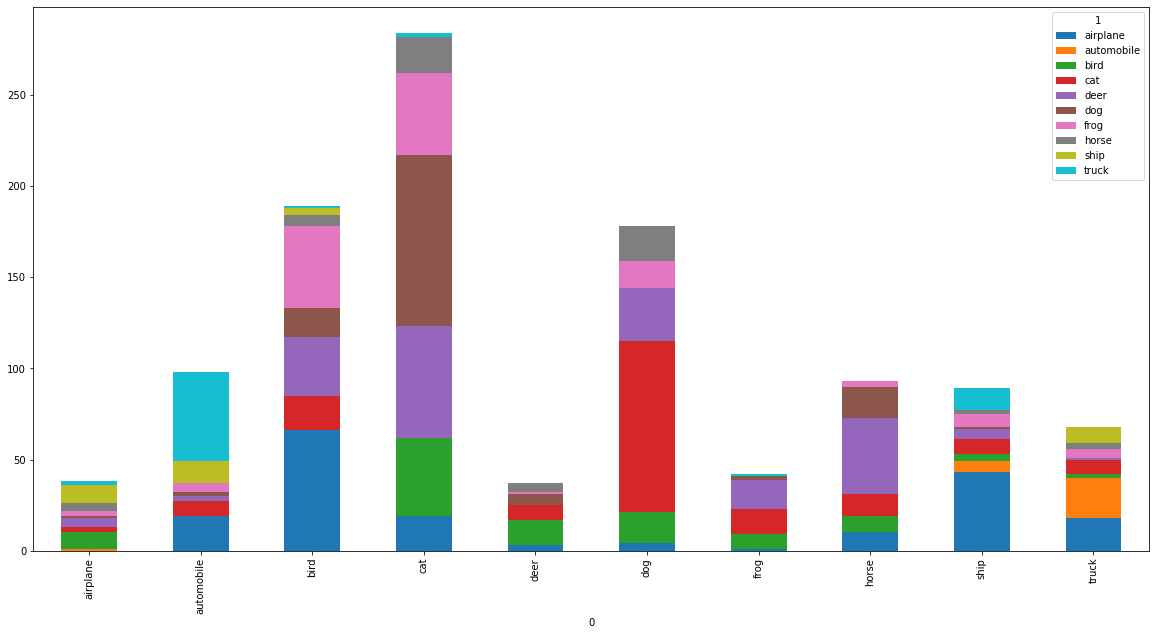

In [34]:
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))


Inferencing Graph

Model is confused between dog,cat & bird, airplane


### plot confusion matrix

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
model = main(0)
pred = []
la=[]
with torch.no_grad():
  for image , label in valLoader:
    image , label = image.to(device) , label.to(device)
    output = model(image)
    output = F.softmax(output,dim=1)
    preds = torch.argmax(output,dim=1)
    pred.extend(preds.clone().detach().cpu().tolist())
    la.extend(label.clone().detach().cpu().tolist())

0it [00:00, ?it/s]


Loaded checkpoint from epoch 25. Best loss so far is 0.299.



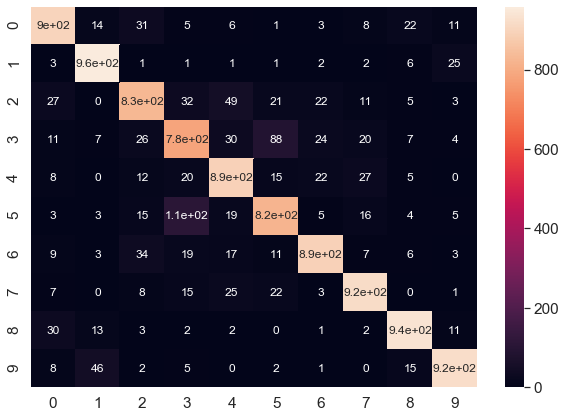

In [36]:
cm = confusion_matrix(la,
                      pred)
 
# Visualizing of confusion matrix
import seaborn as sn
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size

In [37]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Save Model

In [38]:
path = r'C:\Users\91892\Documents\Python_jupyter\Deep Learning\Assignment\Densenet'

In [39]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [40]:

torch.save(model, path+'\CIFAR10_v4.pt')

In [41]:
the_model = torch.load(path+'\CIFAR10_v4.pt')

In [42]:
def Infer(model, image_input):
    import torch
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
    
    model = model.to(device)
    model.eval()
    out = model(image_input)#.squeeze(0)
    prob = torch.argmax(out).item()
    #print(prob)
    return(classes[prob])

In [43]:
def input_image(path):
    from pathlib import Path
    from PIL import Image
    import torch
    from torchvision import  transforms
    size = 32,32
    img = Image.open(path)
    img.thumbnail(size, Image.ANTIALIAS)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(device)
    return(img)

In [50]:
inp = input_image('cat.jpg')

In [51]:
inp1 = input_image('truck.jpg')

In [52]:
inp1.shape

torch.Size([1, 3, 32, 32])

In [53]:
Infer(the_model, inp)

'cat'